In [1]:

import re, random, numpy as np, pandas as pd, torch
import torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
import scipy as sp
from scipy.stats import kendalltau
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import copy

# import seaborn as sns   # FIXME: maybe use this for heatmaps later


In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.use_deterministic_algorithms(True)


### Data and Feature Learning

In [3]:

# Community-level dict

community_contexts = {
    "Community 1": {
        "community_id":"C001",
        "social_vulnerability_score":2,
        "community_geographical_class":"Rural"
},
    "Community 2": {
        "community_id":"C002",
        "social_vulnerability_score":3,
        "community_geographical_class":"Suburban"
},
    "Community 3": {
        "community_id":"C003",
        "social_vulnerability_score":7,
        "community_geographical_class":"Urban"
}
}

# TODO: verify SVS values

 
# Build Features 
resource_types = ["water", "power"]
facility_types = ["hospital", "residential", "school", "commercial"]
communities    = list(community_contexts.keys())
densities      = ["Rural", "Suburban", "Urban"]
VEC_LEN        = 2 + 4 + 3 + 3 + 1  # 13

def build_option_features(text: str) -> torch.Tensor:
    tokens = text.lower().split()
    # resource
    res_vec = np.zeros(len(resource_types))
    for i, r in enumerate(resource_types):
        if r in tokens:
            res_vec[i] = 1
            break
    # facility
    fac_vec = np.zeros(len(facility_types))
    for i, f in enumerate(facility_types):
        if f in tokens:
            fac_vec[i] = 1
            break
    # community, density, SVS
    comm_one = np.zeros(len(communities))
    dens_one = np.zeros(len(densities))
    svs_val  = 0.0
    m = re.search(r"Community\s+\d+", text)
    if m:
        comm = m.group(0)
        comm_one[communities.index(comm)] = 1
        dens = community_contexts[comm]["community_geographical_class"]
        dens_one[densities.index(dens)] = 1
        svs_val = community_contexts[comm]["social_vulnerability_score"]/10
    feat = np.concatenate([res_vec, fac_vec, comm_one, dens_one, [svs_val]], dtype=np.float32)
    print(feat)
    return torch.tensor(feat)
    
# sanity check
print("Feature dim:", build_option_features("Repair Water School in Community 2").shape)





[1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.3]
Feature dim: torch.Size([13])


### Data

In [36]:
# Read CSV, get aggregated soft labels
df = pd.read_csv("data/personas_and_responses_unbiased_original.csv")
# df = pd.read_csv("data/personas_and_responses_biased.csv")
#df = pd.read_csv("data/personas_and_responses_choice_first.csv")
#df = pd.read_csv("data/personas_and_responses_instruction_format.csv")
#df = pd.read_csv("data/personas_and_responses_shifting_tone.csv")
#df = pd.read_csv("data/personas_and_responses_unbiased_rewording_question.csv")
#df = pd.read_csv("data/personas_and_responses_unbiased_rewording_reasoning.csv")
#df = pd.read_csv("data/personas_and_responses_without_svs.csv")


print("Rows in raw data:", len(df))
df["label"] = (df["priority_choice"] != df["option1"]).astype(int)

df_agg = (
    df.groupby("question_id")
      .agg(count          = ("persona_id","count"),
           option1_count  = ("label", lambda x: (x==0).sum()),
           option2_count  = ("label", lambda x: (x==1).sum()),
           option1_text   = ("option1","first"),
           option2_text   = ("option2","first"))
      .reset_index()
)
df_agg["p1"] = df_agg["option1_count"]/df_agg["count"]
df_agg["p2"] = df_agg["option2_count"]/df_agg["count"]

print("Aggregated questions:", len(df_agg))


# Encode each repair option
df_agg["opt1_feat"] = df_agg["option1_text"].apply(build_option_features)
df_agg["opt2_feat"] = df_agg["option2_text"].apply(build_option_features)
# minor debugging
#print(df_agg.head())

# Build the list-of-dict rows expected 
rows = []
for _, r in df_agg.iterrows():
    rows.append({
        "x1": r["opt1_feat"], 
        "x2": r["opt2_feat"],
        "soft_label": torch.tensor([r["p1"],r["p2"]], dtype=torch.float32),
        "name1": r["option1_text"],
        "name2": r["option2_text"]
    })
print("Constructed rows:", len(rows))



Rows in raw data: 7200
Aggregated questions: 36
[1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.2]
[1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.2]
[1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.2]
[1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.2]
[1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.2]
[1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.2]
[1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.2]
[1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.2]
[0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.2]
[0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.2]
[0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.2]
[0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.2]
[0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.2]
[0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.2]
[0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.2]
[1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.2]
[1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.2]
[1.  0.  0.  1.  0.  0.  1.  0.  0

In [6]:
df_agg

,question_id,count,option1_count,option2_count,option1_text,option2_text,p1,p2,opt1_feat,opt2_feat
0,Q001,200,197,3,Repair Water School in Community 1,Repair Power Residential in Community 1,0.985,0.015,"[tensor(1.), tensor(0.), tensor(0.), tensor(0....","[tensor(0.), tensor(1.), tensor(0.), tensor(1...."
1,Q002,200,146,54,Repair Water School in Community 1,Repair Water Residential in Community 1,0.730,0.270,"[tensor(1.), tensor(0.), tensor(0.), tensor(0....","[tensor(1.), tensor(0.), tensor(0.), tensor(1...."
2,Q003,200,146,54,Repair Water School in Community 1,Repair Power Residential in Community 2,0.730,0.270,"[tensor(1.), tensor(0.), tensor(0.), tensor(0....","[tensor(0.), tensor(1.), tensor(0.), tensor(1...."
3,Q004,200,107,93,Repair Water School in Community 1,Repair Water Residential in Community 2,0.535,0.465,"[tensor(1.), tensor(0.), tensor(0.), tensor(0....","[tensor(1.), tensor(0.), tensor(0.), tensor(1...."
4,Q005,200,188,12,Repair Water School in Community 1,Repair Water Commercial in Community 2,0.940,0.060,"[tensor(1.), tensor(0.), tensor(0.), tensor(0....","[tensor(1.), tensor(0.), tensor(0.), tensor(0...."
5,Q006,200,10,190,Repair Water School in Community 1,Repair Water School in Community 3,0.050,0.950,"[tensor(1.), tensor(0.), tensor(0.), tensor(0....","[tensor(1.), tensor(0.), tensor(0.), tensor(0...."
6,Q007,200,101,99,Repair Water School in Community 1,Repair Power Residential in Community 3,0.505,0.495,"[tensor(1.), tensor(0.), tensor(0.), tensor(0....","[tensor(0.), tensor(1.), tensor(0.), tensor(1...."
7,Q008,200,68,132,Repair Water School in Community 1,Repair Water Residential in Community 3,0.340,0.660,"[tensor(1.), tensor(0.), tensor(0.), tensor(0....","[tensor(1.), tensor(0.), tensor(0.), tensor(1...."
8,Q009,200,105,95,Repair Power Residential in Community 1,Repair Water Residential in Community 1,0.525,0.475,"[tensor(0.), tensor(1.), tensor(0.), tensor(1....","[tensor(1.), tensor(0.), tensor(0.), tensor(1...."
9,Q010,200,50,150,Repair Power Residential in Community 1,Repair Power Residential in Community 2,0.250,0.750,"[tensor(0.), tensor(1.), tensor(0.), tensor(1....","[tensor(0.), tensor(1.), tensor(0.), tensor(1...."


In [7]:
#Skip if model using new data and model is trained already. 

# Dataset wrapper
class PairwiseDataset(Dataset):
    def __init__(self, rows): self.rows = rows
    def __len__(self):        return len(self.rows)
    def __getitem__(self, i):
        r = self.rows[i]
        return r["x1"], r["x2"], r["soft_label"]


#Comparator network
class Comparator(nn.Module):
    def __init__(self, d_in, h=64):
        super().__init__()
        self.f    = nn.Sequential(nn.Linear(d_in, h), nn.ReLU(),
                                  nn.Linear(h, h), nn.ReLU())
        self.head = nn.Linear(h*2, 2)
        #self.head = nn.Linear(3 * h + 1, 2)
    def forward(self, a, b):
        f1 = self.f(a)
        f2 = self.f(b)
        #diff = torch.abs(f1 - f2)           # absolute feature differences
        #dot  = (f1 * f2).sum(dim=1, keepdim=True)  # similarity
        
        #combined = torch.cat([f1, f2, dot], dim=1)
        combined = torch.cat([f1, f2], dim=1)
        return self.head(combined)



# Hybrid loss  
def hybrid_loss(logits, soft):
    probs = torch.softmax(logits, 1).clamp(1e-9,1-1e-9)
    loss  = 0.0
    for i in range(soft.size(0)):
        t = soft[i]
        if torch.isclose(t[0], t[1], atol=1e-6):
            # equal = [0.5,0.5]
            loss += F.kl_div(torch.log(probs[i]), torch.tensor([0.5,0.5], device=logits.device),
                             reduction="sum")
        else:
            hard = 0 if t[0]>t[1] else 1
            #loss += F.cross_entropy(logits[i].unsqueeze(0),torch.tensor([hard], device=logits.device))
            loss += F.cross_entropy(logits[i:i+1], torch.tensor([hard], device=logits.device))

    return loss/soft.size(0)


#  k-fold CV 


def kfold_cv(row_list, k=6, lr=0.001, epochs=60, batch=8, tag="lr1e-3"):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    arr = np.array(row_list, dtype=object)
    curve_tr, curve_val, best_each = [], [], []

    for fold, (tr, val) in enumerate(kf.split(arr), 1):
        print(f"\n>> Fold {fold}")
        tr_loader = DataLoader(PairwiseDataset(arr[tr].tolist()), batch_size=batch, shuffle=True)
        val_loader = DataLoader(PairwiseDataset(arr[val].tolist()), batch_size=batch, shuffle=False)
        model = Comparator(VEC_LEN)
        opt = torch.optim.Adam(model.parameters(), lr=lr)
        best_loss, bad_epochs = 1e9, 0
        best_state = None
        hist_tr, hist_val = [], []

        for ep in range(epochs):
            # Train
            model.train()
            run = 0.0
            for a, b, y in tr_loader:
                opt.zero_grad()
                loss = hybrid_loss(model(a, b), y)
                loss.backward()
                opt.step()
                run += loss.item()
            loss_tr = run / len(tr_loader)

            # Validate
            model.eval()
            run = 0.0
            with torch.no_grad():
                for a, b, y in val_loader:
                    run += hybrid_loss(model(a, b), y).item()
            loss_val = run / len(val_loader)

            hist_tr.append(loss_tr)
            hist_val.append(loss_val)

            if ep % 20 == 0:
                print(f"  ep {ep:02d}: train={loss_tr:.3f}, val={loss_val:.3f}")

            # Early stopping with in-memory checkpoint
            if loss_val < best_loss - 1e-4:
                best_loss = loss_val
                bad_epochs = 0
                best_state = copy.deepcopy(model.state_dict())
            else:
                bad_epochs += 1
            if bad_epochs >= 6:
                print("  stopping early at ep", ep)
                break

        # Restore best model
        if best_state is not None:
            model.load_state_dict(best_state)

        print(f"• fold {fold} best val loss = {best_loss:.4f}")
        curve_tr.append(hist_tr)
        curve_val.append(hist_val)
        best_each.append(best_loss)
    
        

    plt.figure(figsize=(3.2, 2.4))
    for tr, val in zip(curve_tr, curve_val):
        plt.plot(tr,   alpha=.3, lw=1.0)
        plt.plot(val,  alpha=.6, lw=1.0, ls="--")

    
    
    legend_elems = [
        Line2D([0], [0], color='black', lw=1, alpha=0.3, label='Training loss'),
        Line2D([0], [0], color='black', lw=1, ls='--', alpha=0.6, label='Validation loss'),
    ]
    
    plt.legend(
        handles=legend_elems,
        loc='upper right',
        frameon=False,
        fontsize=7,
        handlelength=2,
        labelspacing=0.3,
        borderpad=0.3
    )
    
    plt.xlabel("Epoch", fontsize=8)
    plt.ylabel("Loss",  fontsize=8)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.tight_layout(pad=0.5)
    plt.savefig(f"cv_loss_{tag}.png", dpi=300)
    plt.close()


    print(f"\nAverage best val loss across folds: {np.mean(best_each):.4f} ± {np.std(best_each):.4f}")
    return best_each


In [8]:
# Choose LR #Skip too if new data and model is trained already
lr_grid = [0.001, 0.0005, 0.0001]
summary = []
for lr in lr_grid:
    print(f"\n Testing LR: {lr:g} =")
    best = kfold_cv(rows, k=6, lr=lr, epochs=60, batch=8, tag=f"lr{lr:g}")
    summary.append((lr, np.mean(best)))
print("\n CV summary (mean best-fold val-loss)")
for lr, m in summary:
    print(f"  LR {lr:<7g}: {m:.4f}")


 Testing LR: 0.001 =

>> Fold 1
  ep 00: train=0.694, val=0.682
  ep 20: train=0.319, val=0.374
  stopping early at ep 31
• fold 1 best val loss = 0.3446

>> Fold 2
  ep 00: train=0.704, val=0.713
  ep 20: train=0.401, val=0.325
  ep 40: train=0.198, val=0.078
• fold 2 best val loss = 0.0534

>> Fold 3
  ep 00: train=0.691, val=0.690
  ep 20: train=0.353, val=0.489
  ep 40: train=0.148, val=0.301
  stopping early at ep 44
• fold 3 best val loss = 0.2869

>> Fold 4
  ep 00: train=0.699, val=0.704
  stopping early at ep 6
• fold 4 best val loss = 0.7039

>> Fold 5
  ep 00: train=0.696, val=0.662
  stopping early at ep 6
• fold 5 best val loss = 0.6617

>> Fold 6
  ep 00: train=0.688, val=0.691
  ep 20: train=0.315, val=0.554
  stopping early at ep 33
• fold 6 best val loss = 0.5096

Average best val loss across folds: 0.4267 ± 0.2253

 Testing LR: 0.0005 =

>> Fold 1
  ep 00: train=0.697, val=0.686
  ep 20: train=0.569, val=0.585
  ep 40: train=0.338, val=0.371
  stopping early at ep 58

In [9]:
#best LR
lr = 0.001

### Training Data and Predictions

In [10]:
def train_full_dataset(model, loader, optimizer,
                       epochs=100, patience=6):
    """
    Trains on the full set of pairs with simple early stopping.
    Returns a list of epoch losses.
    """
    model.train()
    best_loss, wait = 1e9, 0
    history = []

    for ep in range(epochs):
        running = 0.0
        for x1, x2, y in loader:
            optimizer.zero_grad()
            loss = hybrid_loss(model(x1, x2), y)
            loss.backward()
            optimizer.step()
            running += loss.item()

        epoch_loss = running / len(loader)
        history.append(epoch_loss)

        # early stop
        if epoch_loss < best_loss - 1e-4:
            best_loss, wait = epoch_loss, 0
            #print("New best! Saving model.")
            torch.save(model.state_dict(), "best_full.pt")
        else:
            wait += 1
            #print(f"No improvement (wait={wait}).")
        if wait >= patience:
            #print(f"Stopping early at epoch {ep}, best loss = {best_loss:.4f}")
            break

    # After training finishes, load best model back into memory
    model.load_state_dict(torch.load("best_full.pt"))

    model.eval()
    #print(f"Stopped at epoch {ep+1:2d} · best loss {best_loss:.4f}")
    return history        # list of floats

def predict_all_pairs(model, option_feat_dict):
    """
    Given a trained model and a dict of {option:features},
    predicts P(optionA > optionB) for all pairs.
    """
    #model.eval()
    names = list(option_feat_dict.keys())
    preds = []

    #print("Predicting all pairs")
    with torch.no_grad():
        for i, a in enumerate(names):
            for j in range(i+1, len(names)):
                b = names[j]
                # prepare inputs
                x1, x2 = option_feat_dict[a].unsqueeze(0), option_feat_dict[b].unsqueeze(0)

                # forward pass
                logits = model(x1, x2)
                p      = torch.softmax(logits, 1)[0].cpu().numpy()  # [pA, pB]
                preds.append((a, b, p[0], p[1]))
                
                # debug print
                if len(preds) % 50 == 0:
                    print(f"  computed {len(preds)} pairs so far")

    
    #print(f"Done predicting {len(preds)} pairs.")
    return preds

def pagerank_chainization(pairwise_predictions):
    """
    Build a DiGraph from pairwise_predictions and run PageRank.
    Returns a list of options sorted by descending PageRank score.
    """
    G = nx.DiGraph()

    # Extract all unique items from predictions
    all_items = set()
    for a, b, _, _ in pairwise_predictions:
        all_items.update([a, b])
    
    # Ensure all nodes exist in the graph
    G.add_nodes_from(all_items)

    #print("Building graph")
    for option1, option2, prob1, prob2 in pairwise_predictions:
        if prob1 > prob2:
            G.add_edge(option2, option1, weight=prob1)
        else:
            G.add_edge(option1, option2, weight=prob2)
        
    # PageRank scores
    ranking = nx.pagerank(G) 
    ranked_list = sorted(ranking.keys(), key=lambda x: ranking[x], reverse=True)  # Most important will come first
    return ranked_list

def pagerank_chainization(pairwise_predictions):
    G = nx.DiGraph()
    items = set()
    for a,b,p1,p2 in pairwise_predictions:
        items.add(a); items.add(b)
        if p1 > p2:
            G.add_edge(b, a, weight=p1)
        elif p2 > p1:
            G.add_edge(a, b, weight=p2)
        else:
            G.add_edge(a, b, weight=0.5); G.add_edge(b, a, weight=0.5)
    G.add_nodes_from(items)
    scores = nx.pagerank(G, alpha=0.85)
    return sorted(scores.keys(), key=lambda x: -scores[x])


In [11]:
# option_features = {}
# for _, row in df_agg.iterrows():
#     if row["option1_text"] not in option_features:
#         option_features[row["option1_text"]] = row["opt1_feat"]
#     if row["option2_text"] not in option_features:
#         option_features[row["option2_text"]] = row["opt2_feat"]

# reference_rank = bootstrapped_reference_rank(models, option_features)
# reference_rank 

### Get Global Ranking: Apply the Ranking Algorithm with chosen LR on the 36 pairs

Load new dataset for biased and from prompt changes and run from this line. No need to train the parameters again

In [37]:
#Re-initialise the model with the chosen LR
full_loader = DataLoader(PairwiseDataset(rows), batch_size=8, shuffle=True)
model_full  = Comparator(VEC_LEN)
opt_full    = torch.optim.Adam(model_full.parameters(), lr=lr)


# Train on All 36 pairs
loss_curve  = train_full_dataset(model_full, full_loader, opt_full)

# One dictionary of {option_text : feature_tensor}
option_features = {}
for _, row in df_agg.iterrows():
    if row["option1_text"] not in option_features:
        option_features[row["option1_text"]] = row["opt1_feat"]
    if row["option2_text"] not in option_features:
        option_features[row["option2_text"]] = row["opt2_feat"]



# Predict every pair, build graph, apply chainization
full_pairs     = predict_all_pairs(model_full, option_features)
#print(full_pairs)
reference_rank = pagerank_chainization(full_pairs)


In [38]:
option_features 

{'Repair Water School in Community 1': tensor([1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         1.0000, 0.0000, 0.0000, 0.2000]),
 'Repair Power Residential in Community 1': tensor([0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         1.0000, 0.0000, 0.0000, 0.2000]),
 'Repair Water Residential in Community 1': tensor([1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         1.0000, 0.0000, 0.0000, 0.2000]),
 'Repair Power Residential in Community 2': tensor([0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 1.0000, 0.0000, 0.3000]),
 'Repair Water Residential in Community 2': tensor([1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 1.0000, 0.0000, 0.3000]),
 'Repair Water Commercial in Community 2': tensor([1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 1.0000, 0.0000, 0.3000]),
 'Re

In [39]:
reference_rank 
# ['Repair Water School in Community 3',
#  'Repair Water School in Community 1',
#  'Repair Power Residential in Community 2',
#  'Repair Power Residential in Community 3',
#  'Repair Water Residential in Community 3',
#  'Repair Water Residential in Community 2',
#  'Repair Water Residential in Community 1',
#  'Repair Power Residential in Community 1',
#  'Repair Water Commercial in Community 2']

['Repair Water School in Community 3',
 'Repair Power Residential in Community 3',
 'Repair Water Residential in Community 3',
 'Repair Water Residential in Community 2',
 'Repair Power Residential in Community 2',
 'Repair Water School in Community 1',
 'Repair Water Residential in Community 1',
 'Repair Water Commercial in Community 2',
 'Repair Power Residential in Community 1']

### Random Subsampling  + Pseudo Pair Addition

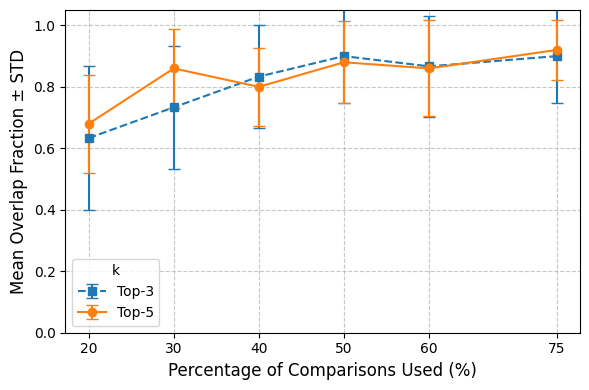

In [13]:
# Rank Estimation using PageRank
def predict_and_rank(new_features, model):
    model.eval()
    names = list(new_features.keys())
    preds = []

    #print("Predicting all pairs")
    with torch.no_grad():
        for i, a in enumerate(names):
            for j in range(i+1, len(names)):
                b = names[j]
                # prepare inputs
                x1, x2 = new_features[a].unsqueeze(0), new_features[b].unsqueeze(0)

                # forward pass
                logits = model(x1, x2)
                p      = torch.softmax(logits, 1)[0].cpu().numpy()  # [pA, pB]
                p1, p2 = p[0], p[1]
                preds.append((a, b, p1, p2))

    G = nx.DiGraph()
    for a, b, p1, p2 in preds:
        if p1 > p2:
            G.add_edge(b, a, weight=p1)
        elif p2 > p1:
            G.add_edge(a, b, weight=p2)

    scores = nx.pagerank(G)
    #return sorted(scores.items(), key=lambda x: -x[1])
    return sorted(scores.keys(), key=lambda x: -scores[x])

# def chainize(items, model, threshold=0.5):
#     """
#     items: list of (name, feature_vector) pairs
#     model: trained comparator
#     threshold: probability cutoff for preference
#     Returns: list of item names in (approximate) total order
#     """
#     # Build directed graph: edge from i to j if i > j
#     G = nx.DiGraph()
#     names = [name for name, _ in items]
#     name2feat = {name: feat for name, feat in items}
#     for i, name_i in enumerate(names):
#         for j, name_j in enumerate(names):
#             if i == j:
#                 continue
#             #x1 = torch.tensor(name2feat[name_i], dtype=torch.float32).unsqueeze(0)
#             x1 = name2feat[name_i].clone().detach().unsqueeze(0)
#             #x2 = torch.tensor(name2feat[name_j], dtype=torch.float32).unsqueeze(0)
#             x2 = name2feat[name_j].clone().detach().unsqueeze(0)
#             with torch.no_grad():
#                 out = model(x1, x2)
#                 prob_i_beats_j = out[0, 0].item()
#             # If probability exceeds threshold, i is preferred over j
#             if prob_i_beats_j > threshold:
#                 G.add_edge(name_j, name_i, weight=prob_i_beats_j)
                    
#     # # Try topological sort first (only works if graph is a DAG)
#     # try:
#     #     order = list(nx.topological_sort(G))
#     #     order = order[::-1]  # Reverse for most preferred first
#     pr = nx.pagerank(G)
#     order = [k for k, v in sorted(pr.items(), key=lambda x: -x[1])]
#     return order

def top_k_overlap(predicted, reference, k):
    top_p = set(predicted[:k])
    top_r = set(reference[:k])
    ov   = top_p & top_r
    return len(ov), len(ov)/k

# Random subset selection 
def select_random_pairs(df, fraction=0.25, seed=42):
    np.random.seed(seed)
    all_indices = df.index.tolist()
    num_to_select = int(len(all_indices) * fraction)
    selected_indices = np.random.choice(all_indices, size=num_to_select, replace=False)
    return df.loc[selected_indices].reset_index(drop=True)


# Generate pseudo-pairs from chain
def generate_pseudo_pairs_from_chain(chain, feature_lookup, window_size=2):
    pseudo_pairs = []
    n = len(chain)
    for i in range(n):
        for j in range(i+1, min(i+1+window_size, n)):
            f1 = feature_lookup[chain[i]]
            f2 = feature_lookup[chain[j]]
            #pseudo_pairs.append((f1, f2, [1.0, 0.0]))  # chain[i] > chain[j]
            pseudo_pairs.append({
                "x1": f1,
                "x2": f2,
                "soft_label": torch.tensor([1.0, 0.0], dtype=torch.float32)
            })
    return pseudo_pairs


# Finetune comparator

#rankings as dictionaries
def create_ranking_dict(ranked_list):
    return {name: idx for idx, name in enumerate(ranked_list)}

# Compare two rankings
def evaluate_ranking(predicted, reference):
    pr = {name:i for i,name in enumerate(predicted)}
    rr = {name:i for i,name in enumerate(reference)}
    common = list(set(pr) & set(rr))
    ps = [pr[n] for n in common]
    rs = [rr[n] for n in common]
    tau, _ = kendalltau(ps, rs)
    return tau

#Monte Carlo on Multiple fractions
fractions = [0.2, 0.3, 0.4, 0.5,0.60, 0.75]
n_trials = 10
results = {f: [] for f in fractions}

# my containers for metrics
tau_results    = {f: [] for f in fractions}
topk_results   = {k: {f: [] for f in fractions} for k in (3,5)}

for trial in range(n_trials):
    for frac in fractions:
        partial_df = select_random_pairs(df_agg, fraction=frac, seed=random.randint(0, 10000))
        if len(partial_df) == 0:
            continue
        real_pairs = []
        for idx, row in partial_df.iterrows():
            #if abs(row['p1'] - row['p2']) >= 0.4:  # filter out ambiguous labels
            real_pairs.append({
                            "x1": row['opt1_feat'],
                            "x2": row['opt2_feat'],
                            "soft_label": torch.tensor([row['p1'], row['p2']], dtype=torch.float32)
                            })

        
        partial_model = Comparator(VEC_LEN)
        optimizer_partial = torch.optim.Adam(partial_model.parameters(), lr=lr)
        partial_dataset = PairwiseDataset(real_pairs)
        partial_dataloader = DataLoader(partial_dataset, batch_size=8, shuffle=True)
        
        train_full_dataset(partial_model, partial_dataloader, optimizer_partial) #fix training
        
        feature_lookup = {}
        for _, row in df_agg.iterrows():
            if row["option1_text"] not in feature_lookup:
                feature_lookup[row["option1_text"]] = row["opt1_feat"]
            if row["option2_text"] not in feature_lookup:
                feature_lookup[row["option2_text"]] = row["opt2_feat"]


        #items = [(name, feature_lookup[name]) for name in list(set(feature_lookup.keys()))]
        
        # #Predict partial ranking from initial training to generate pseudo-pairs
        # #ranked_partial = chainize(items, partial_model)#
        pairwise_preds = predict_and_rank(feature_lookup, partial_model)
        #print(pairwise_preds)
        #ranked_partial = pagerank_chainization(pairwise_preds)


        pseudo_pairs = generate_pseudo_pairs_from_chain(pairwise_preds, feature_lookup,window_size=5)
        
        #print("pseudo_pairs",pseudo_pairs )
        
        # # Combine original and pseudo pairs for fine-tuning 
        # # Gather training examples from partial_df
        # # Combine
        finetune_pairs = real_pairs + pseudo_pairs
        #print("real_pairs",real_pairs)
        #print("pseudo_pairs",pseudo_pairs)

        finetune_dataset = PairwiseDataset(finetune_pairs)
        finetune_dataloader = DataLoader(finetune_dataset, batch_size=8, shuffle=True)
        
        # Re-initialize or re-use your model for fine-tuning
        # You can also continue training on the same model for more epochs
        train_full_dataset(partial_model, finetune_dataloader, optimizer_partial)

        #print("feature_lookup",feature_lookup)
        #Final global ranking (chainization) 
        
        #ranked_partial = predict_and_rank(feature_lookup, partial_model)
        pairwise_preds = predict_all_pairs(partial_model, feature_lookup)
        ranked_partial = pagerank_chainization(pairwise_preds)
        

        #Get a list of the ranked_partial elements
        ranked_partial_ls = []
        for i in ranked_partial:
            #print("i",i)
            ranked_partial_ls.append(i)
        #print("reference_rank",reference_rank)
        common_items = set(reference_rank) & set(ranked_partial)
        #print("Common_items",len(common_items))
        tau = evaluate_ranking(ranked_partial_ls, reference_rank)
        #print("partial",ranked_partial_ls[:5])
        #print("reference", reference_rank[:5])
        tau_results[frac].append(tau)
        #record Top-k overlap
        for k in (3,5):
            cnt, frac_overlap = top_k_overlap(ranked_partial_ls,
                                              reference_rank, k)
            topk_results[k][frac].append(frac_overlap)



# compute means & stds
tau_means = [np.mean(tau_results[f]) for f in fractions]
tau_stds  = [np.std( tau_results[f]) for f in fractions]

topk_summary = {}
for k in (3,5):
    topk_summary[k] = {
        "means": [np.mean(topk_results[k][f]) for f in fractions],
        "stds":  [np.std( topk_results[k][f]) for f in fractions]
    }


#topk_summary


# Given summary data
fractions_pct = [20, 30, 40, 50, 60, 75]
# Plot Top-k Overlap
plt.figure(figsize=(6, 4))
for k in [3, 5]:
    means = topk_summary[k]['means']
    stds  = topk_summary[k]['stds']
    style = 'o-' if k == 5 else 's--'
    plt.errorbar(fractions_pct, means, yerr=stds, fmt=style, capsize=4, label=f'Top-{k}')

plt.xlabel('Percentage of Comparisons Used (%)', fontsize=12)
plt.ylabel('Mean Overlap Fraction ± STD', fontsize=12)
#plt.title('Top-k Overlap vs. Fraction of Comparisons', fontsize=13)
plt.legend(title='k', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fractions_pct, fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

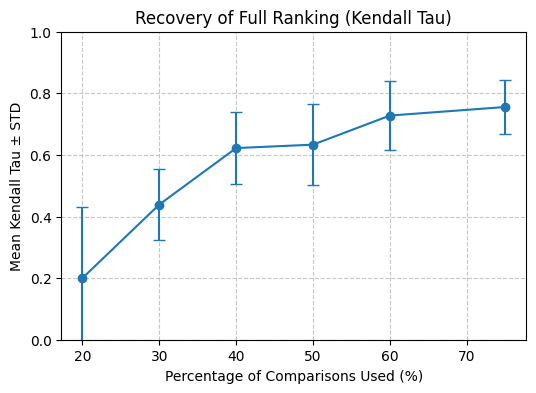

In [21]:
plt.figure(figsize=(6,4))
plt.errorbar(fractions_pct, tau_means, yerr=tau_stds, fmt='o-', capsize=4)
plt.xlabel('Percentage of Comparisons Used (%)')
plt.ylabel('Mean Kendall Tau ± STD')
#plt.title('Recovery of Full Ranking (Kendall Tau)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0,1)
plt.show()
